In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the SMOTE-resampled dataset
dataset_path = r"C:\Users\sudee\OneDrive\Documents\GitHub\MINOR_2-NETWORK-ANAMOLY-DETECTION\DATASET\SMOTE_resampled_dataset.csv"
df = pd.read_csv(dataset_path)

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset shape: (1500000, 79)

First few rows:
    Destination Port   Flow Duration   Total Fwd Packets  \
0                 80        84836302                   9   
1                 53           31272                   2   
2              21184            8233                  15   
3                443         2262744                  11   
4                443       117998131                  38   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        7                          331   
1                        2                           76   
2                        6                        19897   
3                       12                         1884   
4                       31                         8003   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                         11595                     331   
1                           180                      38   
2                             0                    2896   
3 

In [15]:
# Check for null values
print("=" * 60)
print("NULL VALUES CHECK")
print("=" * 60)

null_counts = df.isnull().sum()
null_percentage = (df.isnull().sum() / len(df)) * 100

null_df = pd.DataFrame({
    'Column': null_counts.index,
    'Null_Count': null_counts.values,
    'Null_Percentage': null_percentage.values
})

# Filter only columns with null values
null_df = null_df[null_df['Null_Count'] > 0].sort_values('Null_Count', ascending=False)

if len(null_df) > 0:
    print("\nColumns with null values:")
    print(null_df)
else:
    print("\nNo null values found in the dataset!")

print(f"\nTotal cells in dataset: {df.size}")
print(f"Total null cells: {df.isnull().sum().sum()}")

NULL VALUES CHECK

No null values found in the dataset!

Total cells in dataset: 118500000
Total null cells: 0


In [16]:
# Check data types
print("\n" + "=" * 60)
print("DATA TYPES")
print("=" * 60)
print(df.dtypes)


DATA TYPES
 Destination Port                int64
 Flow Duration                   int64
 Total Fwd Packets               int64
 Total Backward Packets          int64
Total Length of Fwd Packets      int64
                                ...   
Idle Mean                      float64
 Idle Std                      float64
 Idle Max                        int64
 Idle Min                        int64
 Label                           int64
Length: 79, dtype: object



CORRELATION MATRIX ANALYSIS


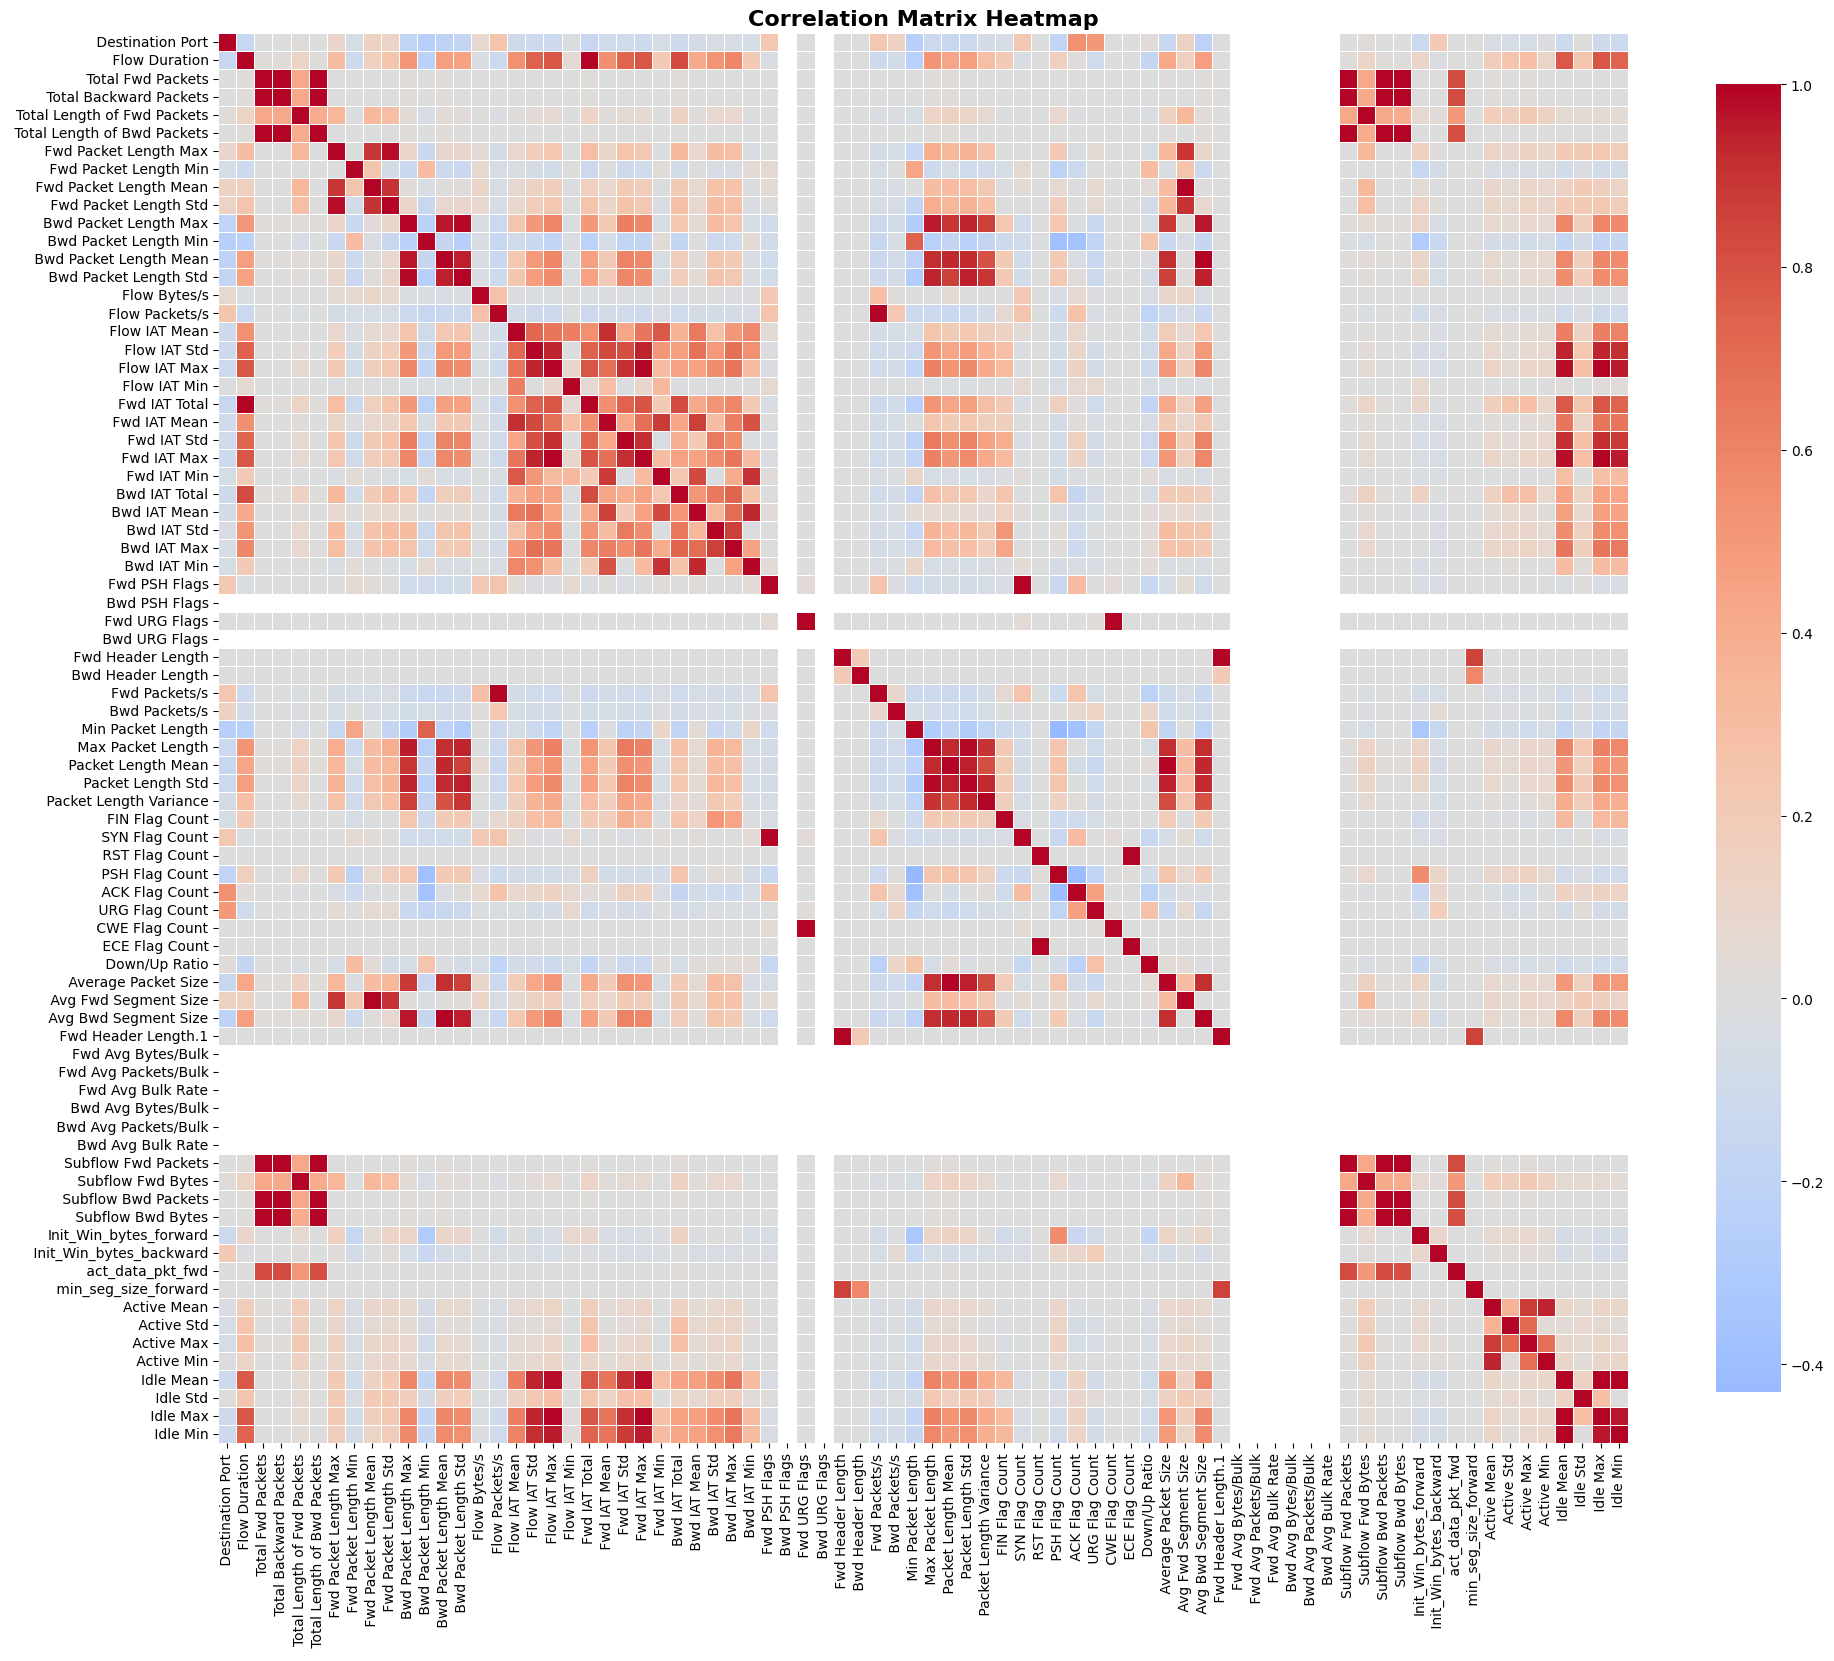

Correlation matrix heatmap saved!


In [17]:
# Separate features and target
X = df.drop(columns=[' Label'])
y = df[' Label']

print("\n" + "=" * 60)
print("CORRELATION MATRIX ANALYSIS")
print("=" * 60)

# Calculate correlation matrix
correlation_matrix = X.corr()

# Create a large figure for the heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(
    correlation_matrix, 
    annot=False,  # Too many features to annotate
    cmap='coolwarm', 
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('Correlation Matrix Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(
    r"C:\Users\sudee\OneDrive\Documents\GitHub\MINOR_2-NETWORK-ANAMOLY-DETECTION\correlation_matrix_heatmap.png",
    dpi=100,
    bbox_inches='tight'
)
plt.show()

print("Correlation matrix heatmap saved!")

In [18]:
# Find highly correlated features (correlation > 0.95 with other features)
print("\n" + "=" * 60)
print("HIGHLY CORRELATED FEATURES (Correlation > 0.95)")
print("=" * 60)

def find_highly_correlated_pairs(corr_matrix, threshold=0.95):
    """Find pairs of features with correlation > threshold"""
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_value = abs(corr_matrix.iloc[i, j])
            if corr_value > threshold:
                corr_pairs.append({
                    'Feature_1': corr_matrix.columns[i],
                    'Feature_2': corr_matrix.columns[j],
                    'Correlation': corr_matrix.iloc[i, j]
                })
    return pd.DataFrame(corr_pairs).sort_values('Correlation', ascending=False, key=abs)

highly_corr = find_highly_correlated_pairs(correlation_matrix, threshold=0.95)

if len(highly_corr) > 0:
    print(f"\nFound {len(highly_corr)} highly correlated pairs:")
    print(highly_corr.to_string(index=False))
else:
    print("\nNo feature pairs with correlation > 0.95 found.")

# Features to consider removing (one from each highly correlated pair)
print("\n" + "=" * 60)
print("CANDIDATE FEATURES FOR REMOVAL")
print("=" * 60)
if len(highly_corr) > 0:
    features_to_remove = set(highly_corr['Feature_2'].values)
    print(f"\nConsider removing these features (keep Feature_1 from each pair):")
    for idx, feature in enumerate(sorted(features_to_remove), 1):
        print(f"{idx}. {feature}")
else:
    print("\nNo features recommended for removal based on high correlation.")


HIGHLY CORRELATED FEATURES (Correlation > 0.95)

Found 41 highly correlated pairs:
                   Feature_1                    Feature_2  Correlation
      Bwd Packet Length Mean         Avg Bwd Segment Size     1.000000
      Total Backward Packets          Subflow Bwd Packets     1.000000
               Fwd URG Flags               CWE Flag Count     1.000000
      Fwd Packet Length Mean         Avg Fwd Segment Size     1.000000
           Fwd Header Length          Fwd Header Length.1     1.000000
              RST Flag Count               ECE Flag Count     1.000000
 Total Length of Fwd Packets            Subflow Fwd Bytes     1.000000
               Fwd PSH Flags               SYN Flag Count     1.000000
           Total Fwd Packets          Subflow Fwd Packets     1.000000
 Total Length of Bwd Packets            Subflow Bwd Bytes     1.000000
      Total Backward Packets          Subflow Fwd Packets     0.999592
           Total Fwd Packets       Total Backward Packets     0.

In [19]:
# Feature importance based on correlation with target
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE (Correlation with Target)")
print("=" * 60)

# Add target to correlation analysis
df_with_target = X.copy()
df_with_target['Target'] = y

target_corr = df_with_target.corr()['Target'].drop('Target').abs().sort_values(ascending=False)

print("\nTop 20 features by absolute correlation with target:")
print(target_corr.head(20))

print("\n\nBottom 20 features by absolute correlation with target (weakest predictors):")
print(target_corr.tail(20))

# Features with very low correlation (< 0.01) - candidates to drop
weak_features = target_corr[target_corr < 0.01]
if len(weak_features) > 0:
    print(f"\n\nFeatures with very weak correlation (< 0.01) with target ({len(weak_features)} features):")
    print(weak_features)


FEATURE IMPORTANCE (Correlation with Target)



Top 20 features by absolute correlation with target:
 URG Flag Count    0.040429
 SYN Flag Count    0.040417
Fwd PSH Flags      0.040417
 ACK Flag Count    0.039378
 Down/Up Ratio     0.034551
FIN Flag Count     0.027847
 PSH Flag Count    0.013470
 Bwd IAT Std       0.013356
 Bwd IAT Max       0.011529
Flow Bytes/s       0.010853
 Fwd IAT Std       0.010620
 Idle Min          0.010358
Idle Mean          0.010332
 Idle Max          0.009990
 RST Flag Count    0.009802
 ECE Flag Count    0.009802
 Fwd IAT Max       0.009359
 Flow IAT Max      0.009016
Bwd IAT Total      0.008577
 Bwd Packets/s     0.008504
Name: Target, dtype: float64


Bottom 20 features by absolute correlation with target (weakest predictors):
 Fwd Header Length.1      0.001440
 Fwd Header Length        0.001440
 Min Packet Length        0.001361
Fwd Packets/s             0.001283
 Bwd Packet Length Min    0.001233
Active Mean               0.001094
 Fwd IAT Mean             0.000823
 Bwd Header Length        0.00070

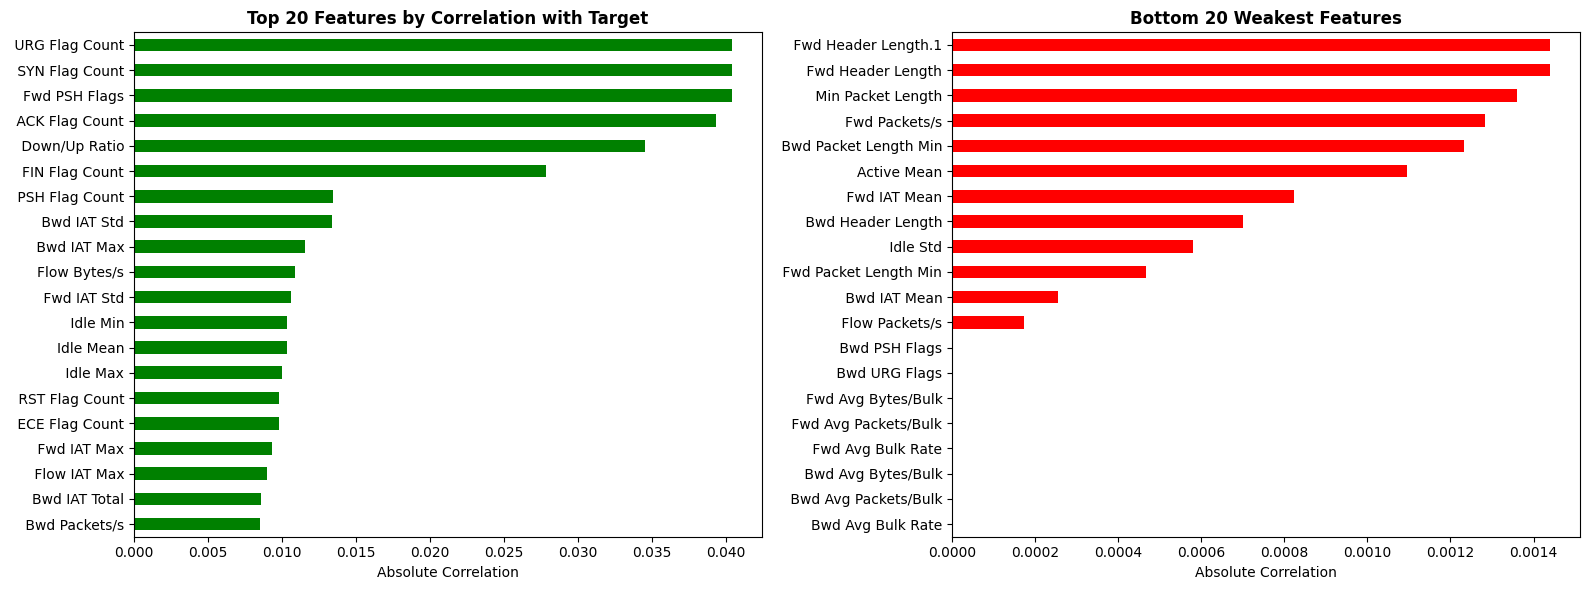

Feature importance plot saved!


In [20]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 features
target_corr.head(20).plot(kind='barh', ax=axes[0], color='green')
axes[0].set_title('Top 20 Features by Correlation with Target', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Absolute Correlation')
axes[0].invert_yaxis()

# Weak features (bottom 20)
target_corr.tail(20).plot(kind='barh', ax=axes[1], color='red')
axes[1].set_title('Bottom 20 Weakest Features', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Absolute Correlation')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig(
    r"C:\Users\sudee\OneDrive\Documents\GitHub\MINOR_2-NETWORK-ANAMOLY-DETECTION\feature_importance.png",
    dpi=100,
    bbox_inches='tight'
)
plt.show()

print("Feature importance plot saved!")

In [21]:
# Summary statistics
print("\n" + "=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)

print(f"\nDataset shape: {df.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"\nTarget class distribution:")
print(y.value_counts().sort_index())

# Statistical summary
print("\n\nFeature statistics:")
print(X.describe())


SUMMARY STATISTICS

Dataset shape: (1500000, 79)
Number of features: 78
Number of samples: 1500000

Target class distribution:
 Label
0    300000
1    300000
2    300000
3    300000
4    300000
Name: count, dtype: int64


Feature statistics:
        Destination Port   Flow Duration   Total Fwd Packets  \
count       1.500000e+06    1.500000e+06        1.500000e+06   
mean        8.063327e+03    1.500847e+07        7.335170e+00   
std         1.816082e+04    3.389344e+07        4.834598e+02   
min         0.000000e+00   -1.200000e+01        1.000000e+00   
25%         5.300000e+01    1.580000e+02        1.000000e+00   
50%         8.000000e+01    3.155600e+04        2.000000e+00   
75%         4.430000e+02    3.745892e+06        5.000000e+00   
max         6.553200e+04    1.200000e+08        2.186580e+05   

        Total Backward Packets  Total Length of Fwd Packets  \
count             1.500000e+06                 1.500000e+06   
mean              7.740437e+00                 5.14222

In [ ]:
# # Remove low-importance features
# print("\n" + "=" * 60)
# print("REMOVING LOW-IMPORTANCE FEATURES")
# print("=" * 60)

# features_to_drop = [
#     'Fwd Avg Bytes/Bulk',
#     ' Fwd Avg Packets/Bulk',
#     ' Fwd Avg Bulk Rate',
#     ' Bwd Avg Bytes/Bulk',
#     ' Bwd Avg Packets/Bulk',
#     ' Bwd Avg Bulk Rate'
# ]

# print(f"\nFeatures to remove ({len(features_to_drop)}):")
# for feat in features_to_drop:
#     print(f"  - {feat}")

# # Drop features from X
# X = X.drop(columns=features_to_drop, errors='ignore')

# print(f"\nDataset shape after feature removal: {X.shape}")
# print(f"Remaining features: {X.shape[1]}")

# # Also update df to remove these columns for saving
# df = df.drop(columns=features_to_drop, errors='ignore')

# print("\nFeatures successfully removed!")


REMOVING LOW-IMPORTANCE FEATURES

Features to remove (6):
  - Fwd Avg Bytes/Bulk
  -  Fwd Avg Packets/Bulk
  -  Fwd Avg Bulk Rate
  -  Bwd Avg Bytes/Bulk
  -  Bwd Avg Packets/Bulk
  -  Bwd Avg Bulk Rate

Dataset shape after feature removal: (1500000, 73)
Remaining features: 73

Features successfully removed!


In [4]:
df.columns = df.columns.str.strip()


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 79 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Destination Port             1500000 non-null  int64  
 1   Flow Duration                1500000 non-null  int64  
 2   Total Fwd Packets            1500000 non-null  int64  
 3   Total Backward Packets       1500000 non-null  int64  
 4   Total Length of Fwd Packets  1500000 non-null  int64  
 5   Total Length of Bwd Packets  1500000 non-null  int64  
 6   Fwd Packet Length Max        1500000 non-null  int64  
 7   Fwd Packet Length Min        1500000 non-null  int64  
 8   Fwd Packet Length Mean       1500000 non-null  float64
 9   Fwd Packet Length Std        1500000 non-null  float64
 10  Bwd Packet Length Max        1500000 non-null  int64  
 11  Bwd Packet Length Min        1500000 non-null  int64  
 12  Bwd Packet Length Mean       1500000 non-n

In [6]:
df=df.drop(columns=['Fwd Avg Bytes/Bulk',
    'Fwd Avg Packets/Bulk',
    'Fwd Avg Bulk Rate',
    'Bwd Avg Bytes/Bulk',
    'Bwd Avg Packets/Bulk',
    'Bwd Avg Bulk Rate'])

In [7]:
print(df.shape)


(1500000, 73)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 77 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0    Destination Port             1500000 non-null  int64  
 1    Flow Duration                1500000 non-null  int64  
 2    Total Fwd Packets            1500000 non-null  int64  
 3    Total Backward Packets       1500000 non-null  int64  
 4   Total Length of Fwd Packets   1500000 non-null  int64  
 5    Total Length of Bwd Packets  1500000 non-null  int64  
 6    Fwd Packet Length Max        1500000 non-null  int64  
 7    Fwd Packet Length Min        1500000 non-null  int64  
 8    Fwd Packet Length Mean       1500000 non-null  float64
 9    Fwd Packet Length Std        1500000 non-null  float64
 10  Bwd Packet Length Max         1500000 non-null  int64  
 11   Bwd Packet Length Min        1500000 non-null  int64  
 12   Bwd Packet Length Mean     